#### Import libreries

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tabulate import tabulate
from google.colab import drive
import seaborn as sns
import itertools
import statistics as s
import math
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import os
import sys

## **1. PPI and GDA data gathering and interactome reconstruction**

### 1.1 Download PPIs from BioGRID latest release to build the human interactome

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/MyDrive/BIOGRID-ORGANISM-Homo_sapiens-4.4.228.tab3.txt", delimiter = "\t", low_memory=False)
data.head()

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,103,6416,2318,112315,108607,-,-,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,Q59H94,NP_001120959|NP_001449,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1,117,84665,88,124185,106603,-,-,MYPN,ACTN2,CMD1DD|CMH22|MYOP|RCM4,...,Q59FD9|F6THM6,NP_001094|NP_001265272|NP_001265273,-,-,-,-,-,-,Homo sapiens,Homo sapiens
2,183,90,2339,106605,108625,-,-,ACVR1,FNTA,ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI,...,-,NP_002018,-,-,-,-,-,-,Homo sapiens,Homo sapiens
3,278,2624,5371,108894,111384,-,-,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,...,-,NP_150250|NP_150253|NP_150252|NP_150247|NP_150...,-,-,-,-,-,-,Homo sapiens,Homo sapiens
4,418,6118,6774,112038,112651,RP4-547C9.3,-,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,...,-,NP_644805|NP_003141|NP_001356447|NP_001356443|...,-,-,-,-,-,-,Homo sapiens,Homo sapiens


In [4]:
def filter_data(data):
    data_copy = data.copy()

    # Keep only human interactions
    human_interactions = data_copy[(data_copy['Organism ID Interactor A'] == 9606) & (data_copy['Organism ID Interactor B'] == 9606)]
    print(f"Interazioni umane: {len(human_interactions)}")

    # Keep only physical interactions
    physical_interactions = human_interactions[human_interactions['Experimental System Type'] == 'physical']
    print(f"Interazioni fisiche: {len(physical_interactions)}")

    # Remove self-loops (we used BioGRID ID as unique identifier) and redundancies
    unique_interactions = physical_interactions[physical_interactions['Official Symbol Interactor A'] != physical_interactions['Official Symbol Interactor B']]
    unique_interactions = unique_interactions.drop_duplicates(subset=['Official Symbol Interactor A', 'Official Symbol Interactor B'], keep='first')
    print(f"Interazioni uniche: {len(unique_interactions)}")

    # Remove Organism ID columns
    filtered_data = unique_interactions.drop(['Organism Name Interactor A', 'Organism Name Interactor B'], axis=1)

    return filtered_data

In [5]:
ppi=filter_data(data)
ppi.head()

Interazioni umane: 1104228
Interazioni fisiche: 1085794
Interazioni uniche: 860597


,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,REFSEQ Accessions Interactor A,SWISS-PROT Accessions Interactor B,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types
0,103,6416,2318,112315,108607,-,-,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,NP_003001|NP_001268364,Q14315,Q59H94,NP_001120959|NP_001449,-,-,-,-,-,-
1,117,84665,88,124185,106603,-,-,MYPN,ACTN2,CMD1DD|CMH22|MYOP|RCM4,...,NP_001243197|NP_001243196|NP_115967,P35609,Q59FD9|F6THM6,NP_001094|NP_001265272|NP_001265273,-,-,-,-,-,-
2,183,90,2339,106605,108625,-,-,ACVR1,FNTA,ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI,...,NP_001104537|NP_001096,P49354,-,NP_002018,-,-,-,-,-,-
3,278,2624,5371,108894,111384,-,-,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,...,NP_001139134|NP_116027|NP_001139133,P29590,-,NP_150250|NP_150253|NP_150252|NP_150247|NP_150...,-,-,-,-,-,-
4,418,6118,6774,112038,112651,RP4-547C9.3,-,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,...,NP_001342057|NP_002937|NP_001284487|NP_0013420...,P40763,-,NP_644805|NP_003141|NP_001356447|NP_001356443|...,-,-,-,-,-,-


In [6]:
def isolate_lcc(filtered_data):
    # Create the graph with NetworkX
    G = nx.from_pandas_edgelist(filtered_data, 'Official Symbol Interactor A', 'Official Symbol Interactor B')

    # Identifiy the Largest Connected Component (LCC)
    lcc = max(nx.connected_components(G), key=len)
    lcc_graph = G.subgraph(lcc)

    return lcc_graph, G

In [7]:
def isolate_lcc(filtered_data):
    # Creiamo il grafo con NetworkX usando una copia del DataFrame per evitare modifiche in-place
    filtered_data_copy = filtered_data.copy()
    G = nx.from_pandas_edgelist(filtered_data_copy, 'Official Symbol Interactor A', 'Official Symbol Interactor B')
    print(f"Numero totale di nodi nel grafo: {len(G.nodes())}")
    print(f"Numero totale di archi nel grafo: {len(G.edges())}")

    # Identifichiamo la Largest Connected Component (LCC)
    lcc = max(nx.connected_components(G), key=len)
    lcc_graph = G.subgraph(lcc).copy()
    print(f"Numero di nodi nel LCC: {len(lcc_graph.nodes())}")
    print(f"Numero di archi nel LCC: {len(lcc_graph.edges())}")

    return lcc_graph, G

In [8]:
lcc_graph, G = isolate_lcc(ppi)
print("Numero di nodi nel LCC:", len(lcc_graph.nodes()))
print("Numero di archi nel LCC:", len(lcc_graph.edges()))

Numero totale di nodi nel grafo: 19816
Numero totale di archi nel grafo: 809943
Numero di nodi nel LCC: 19816
Numero di archi nel LCC: 809943
Numero di nodi nel LCC: 19816
Numero di archi nel LCC: 809943


This is an interactive plot, which allows you to select an area for a closer view of the largest component. This feature is particularly useful when the component is too large to be viewed entirely on the screen at once

## 1.2 Gather gene-disease associations (GDAs) data from DisGeNET

In [9]:
tsv_file_path = '/content/C1621958_disease_gda_summary_CURATED.tsv'
disease_df = pd.read_csv(tsv_file_path, sep='\t')
disease_df.head()

,Disease,Disease_id,Gene,Gene_id,UniProt,Gene_Full_Name,Protein_Class,N_diseases_g,DSI_g,DPI_g,pLI,Score_gda,EL_gda,EI_gda,N_PMIDs,N_SNPs_gda,First_Ref,Last_Ref
0,Glioblastoma Multiforme,C1621958,MTOR,2475,P42345,mechanistic target of rapamycin kinase,Kinase,68,0.343,0.885,1.000000e+00,0.60,NaN,0.967,1,0,2005.0,2019.0
1,Glioblastoma Multiforme,C1621958,MDM4,4194,O15151,MDM4 regulator of p53,Nucleic acid binding,20,0.461,0.808,9.999200e-01,0.60,NaN,1.000,1,0,2002.0,2018.0
2,Glioblastoma Multiforme,C1621958,PTK2,5747,Q05397,protein tyrosine kinase 2,Kinase,16,0.497,0.808,9.998700e-01,0.55,NaN,1.000,1,0,2003.0,2019.0
3,Glioblastoma Multiforme,C1621958,BRD2,6046,P25440,bromodomain containing 2,Epigenetic regulator,10,0.450,0.808,9.995700e-01,0.53,NaN,1.000,1,0,1999.0,2018.0
4,Glioblastoma Multiforme,C1621958,IDH1,3417,O75874,isocitrate dehydrogenase (NADP(+)) 1,NaN,45,0.424,0.808,2.624400e-12,0.50,NaN,0.977,0,0,2008.0,2020.0


In [10]:
disease_df.shape

(111, 18)

The disease is associated to 111 genes.

## 1.3 Compute and characterize the disease LCC and its basic network measures.

In [11]:
dis_genes = set(disease_df["Gene"].to_numpy())
subgraph = G.subgraph(dis_genes)

# Find the largest connected component
largest_cc = max(nx.connected_components(subgraph), key=len)

In [12]:
node_colors = ['#FF1493' if node in largest_cc else '#8A2BE2' for node in subgraph.nodes()]
pos = nx.spring_layout(subgraph, seed=42)

# Create a Plotly figure
fig = go.Figure()

# Add nodes to the graph with larger size and text above nodes
for node in subgraph.nodes():
    x, y = pos[node]
    color = '#FF1493' if node in largest_cc else '#8A2BE2'
    fig.add_trace(go.Scatter(
        x=[x],
        y=[y],
        mode='markers+text',
        marker=dict(size=20, color=color),
        text=[node],
        textposition='top center',
        hoverinfo='text'
    ))

# Add edges to the graph
for edge in subgraph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        mode='lines',
        line=dict(width=1, color='black')
    ))

# Update layout parameters
fig.update_layout(
    title='Subgraph of Genes Associated with Diseases',
    showlegend=False,
    width=800,
    height=800,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=40),
)

fig.show()

That is an interactive graph, in this way it is possible to zoom zoom in on areas of interest.

In [13]:
inter_nodes= set(list(G.nodes))
seed_genes = list(inter_nodes.intersection(dis_genes))
sub_seed = G.subgraph(seed_genes)

# Isolate the LCC in the interactome
conn_comp = [c for c in sorted(list(nx.connected_components(sub_seed)), key=len, reverse=True)]
LCC_nodes = conn_comp[0]
LCC = nx.subgraph(sub_seed, LCC_nodes)

In [14]:
data = {
    'Disease Name': ['Glioblastoma Multiforme'],
    'UMLS Disease ID': ['C1621958'],
    'MeSH Disease Class': ['C04'],
    'Number of Associated Genes': [111],
    'Number of Genes Present in the Interactome': [len(seed_genes)],
    'LCC Size of the Disease Interactome': [len(LCC_nodes)]
}

df = pd.DataFrame(data)
table = tabulate(df.head(1), headers='keys', tablefmt='fancy_grid', showindex=False)

print(table)

╒═════════════════════════╤═══════════════════╤══════════════════════╤══════════════════════════════╤══════════════════════════════════════════════╤═══════════════════════════════════════╕
│ Disease Name            │ UMLS Disease ID   │ MeSH Disease Class   │   Number of Associated Genes │   Number of Genes Present in the Interactome │   LCC Size of the Disease Interactome │
╞═════════════════════════╪═══════════════════╪══════════════════════╪══════════════════════════════╪══════════════════════════════════════════════╪═══════════════════════════════════════╡
│ Glioblastoma Multiforme │ C1621958          │ C04                  │                          111 │                                          103 │                                    83 │
╘═════════════════════════╧═══════════════════╧══════════════════════╧══════════════════════════════╧══════════════════════════════════════════════╧═══════════════════════════════════════╛


### Network metrics

In [15]:
LCC = nx.subgraph(sub_seed, LCC_nodes)

# Compute node degree
degree = dict(nx.degree(LCC))

# Compute betweenness centrality
betweenness = nx.betweenness_centrality(LCC)

# Compute eigenvector centrality
eigenvector = nx.eigenvector_centrality(LCC, max_iter=1000)

# Compute closeness centrality
closeness = nx.closeness_centrality(LCC)

# Compute ratio betweenness/node degree
ratio_betweenness_degree = {node: betweenness[node] / degree[node] for node in degree}

# Sort nodes based on degree from higher to lower and select top 50 nodes
sorted_nodes = sorted(degree.keys(), key=lambda x: degree[x], reverse=True)[:50]

# Create a table to report network measures
table_data = []
for node in sorted_nodes:
    table_data.append([node, degree[node], betweenness[node], eigenvector[node], closeness[node], ratio_betweenness_degree[node]])
measures = pd.DataFrame(table_data, columns=['Node', 'Degree', 'Betweenness', 'Eigenvector', 'Closeness', 'Ratio Betweenness/Degree'])


In [16]:
headers = ['Node', 'Degree', 'Betweenness', 'Eigenvector', 'Closeness', 'Ratio Betweenness/Degree']
formatted_table = tabulate(table_data, headers=headers, tablefmt='fancy_grid', showindex=True)
print(formatted_table)

╒════╤═════════╤══════════╤═══════════════╤═══════════════╤═════════════╤════════════════════════════╕
│    │ Node    │   Degree │   Betweenness │   Eigenvector │   Closeness │   Ratio Betweenness/Degree │
╞════╪═════════╪══════════╪═══════════════╪═══════════════╪═════════════╪════════════════════════════╡
│  0 │ MYC     │       33 │   0.306291    │     0.419138  │    0.577465 │                0.00928155  │
├────┼─────────┼──────────┼───────────────┼───────────────┼─────────────┼────────────────────────────┤
│  1 │ EGFR    │       26 │   0.24495     │     0.305947  │    0.554054 │                0.00942115  │
├────┼─────────┼──────────┼───────────────┼───────────────┼─────────────┼────────────────────────────┤
│  2 │ PML     │       20 │   0.10971     │     0.309389  │    0.5      │                0.00548551  │
├────┼─────────┼──────────┼───────────────┼───────────────┼─────────────┼────────────────────────────┤
│  3 │ BRD4    │       18 │   0.107939    │     0.264335  │    0.49697  │

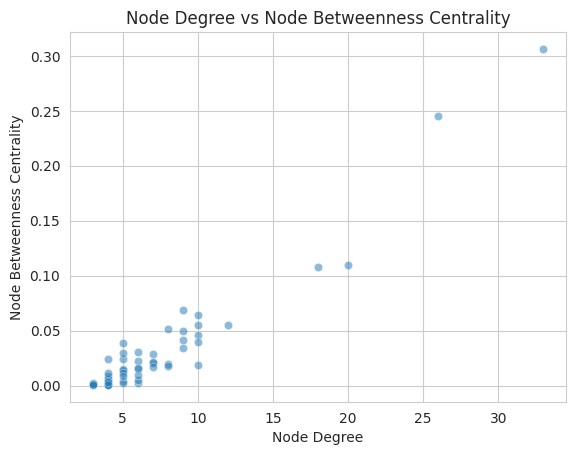

In [17]:
# Set Seaborn style
sns.set_style('whitegrid')

# Create scatter plot with Seaborn
sns.scatterplot(x='Degree', y='Betweenness', data=measures, alpha=0.5)
plt.xlabel('Node Degree')
plt.ylabel('Node Betweenness Centrality')
plt.title('Node Degree vs Node Betweenness Centrality')
plt.show()


## **2. Comparative analysis of the disease genes identification algorithms**

## 2.1 DIAMOnD algorithm

In [18]:
user = "dinaghiassian"
repo = "DIAMOnD"

# Remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

# Clone the repository where the algorithm can be found
!git clone https://github.com/{user}/{repo}.git

sys.path.insert(0,'/content/DIAMOnD')
import DIAMOnD as D

Cloning into 'DIAMOnD'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 64 (delta 2), reused 1 (delta 1), pack-reused 61
Receiving objects: 100% (64/64), 26.88 KiB | 573.00 KiB/s, done.
Resolving deltas: 100% (30/30), done.


In [19]:
DIAMOnD_genes = D.DIAMOnD(G, seed_genes, 100, 5, "DIAMOnD_candidate_genes.txt")

In [20]:
DIAMOnD_genes = pd.read_csv("DIAMOnD_candidate_genes.txt", delimiter ="\t")
DIAMOnD_genes.head(10)

,#rank,DIAMOnD_node,p_hyper
0,1,HSP90AA1,2.179673e-83
1,2,PRKDC,0.000000e+00
2,3,HDAC1,0.000000e+00
3,4,AKT1,0.000000e+00
4,5,AR,0.000000e+00
5,6,STAT3,0.000000e+00
6,7,CDC37,0.000000e+00
7,8,MDM2,0.000000e+00
8,9,VCP,0.000000e+00
9,10,HIST1H4A,0.000000e+00


## 2.1 DiaBLE algorithm

In [21]:
def smallest_local_expansion(graph, seed):
    # Find only nearest deaseas genes
    all_adj = list(set(itertools.chain(*[list(graph.adj[gene]) for gene in seed])))
    nodes_to_visit = seed + all_adj
    sub = graph.subgraph(nodes_to_visit)
    return sub

In [22]:
# Compute the smallest_local_expansion
def smallest_local_expansion(graph, seed):
    all_adj = list(set(itertools.chain(*[list(graph.adj[gene]) for gene in seed])))
    nodes_to_visit = seed + all_adj
    sub = graph.subgraph(nodes_to_visit)
    return sub

# DiaBLE algorithm update
def DiaBLE(graph, seed, n_iter, alpha=2, output_file_name="DiaBLE_candidate_genes.txt"):
    temp_seed = seed.copy()
    DiaBLE_genes = {}

    for i in range(n_iter):
        # Change the universe at each interaction
        sub_universe = smallest_local_expansion(graph, temp_seed)
        DiaBLE_genes[i] = D.DIAMOnD(sub_universe, temp_seed, 1, alpha, f"DiaBLE_candidate_gene_{i}.txt")
        # Update seed genes list
        temp_seed.append(DiaBLE_genes[i][0][0])

    # Sava info
    with open(output_file_name, "w") as file:
        file.write('\t'.join(['#rank', 'DiaBLE_node', 'p_hyper']) + '\n')
        for key, node_info in zip(range(n_iter), DiaBLE_genes.values()):
            candidate_gene = node_info[0]
            DiaBLE_node = candidate_gene[0]
            p = float(candidate_gene[3])

            file.write('\t'.join(map(str, ([key, DiaBLE_node, p]))) + '\n')
    return DiaBLE_genes

In [23]:
DiaBLE(G, seed_genes, 100, 5, "DiaBLE_candidate_genes.txt")

<ipython-input-22-5a2cd0e4741f>:26: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



{0: [('HSP90AA1', 1011, 170, array([1.53986259e-51]))],
 1: [('STAT3', 408, 100, array([2.02383698e-44]))],
 2: [('AKT1', 562, 110, array([8.42652793e-39]))],
 3: [('SIRT1', 399, 90, array([1.34207532e-36]))],
 4: [('TP53', 1775, 205, array([6.26539638e-37]))],
 5: [('MAP2K3', 290, 80, array([8.19873012e-40]))],
 6: [('HSPA4', 640, 120, array([7.86973807e-41]))],
 7: [('CDK1', 539, 110, array([7.38351074e-41]))],
 8: [('RB1', 361, 90, array([1.81299404e-40]))],
 9: [('MDM2', 652, 125, array([3.83428489e-43]))],
 10: [('SP1', 388, 100, array([4.0290602e-46]))],
 11: [('DNMT1', 249, 80, array([1.95438078e-44]))],
 12: [('NBN', 219, 75, array([1.049079e-43]))],
 13: [('E2F1', 212, 75, array([1.15110582e-44]))],
 14: [('KAT5', 335, 95, array([9.16238319e-47]))],
 15: [('TP73', 204, 75, array([9.17356258e-46]))],
 16: [('SKP2', 313, 95, array([2.67318575e-49]))],
 17: [('CDKN1A', 390, 105, array([7.55561249e-49]))],
 18: [('CCNE1', 162, 70, array([5.61224584e-48]))],
 19: [('CREBBP', 540, 1

In [24]:
DiaBLE_cand_df = pd.read_csv("DiaBLE_candidate_genes.txt", delimiter = "\t")
DiaBLE_cand_df.head(10)

,#rank,DiaBLE_node,p_hyper
0,0,HSP90AA1,1.539863e-51
1,1,STAT3,2.023837e-44
2,2,AKT1,8.426528e-39
3,3,SIRT1,1.342075e-36
4,4,TP53,6.265396e-37
5,5,MAP2K3,8.198730e-40
6,6,HSPA4,7.869738e-41
7,7,CDK1,7.383511e-41
8,8,RB1,1.812994e-40
9,9,MDM2,3.834285e-43


In [25]:
DIAMOnD_cand = list(DIAMOnD_genes["DIAMOnD_node"])
DiaBLE_cand = list(DiaBLE_cand_df["DiaBLE_node"])
len(set(DiaBLE_cand).intersection(set(DIAMOnD_cand)))

25

## 2.1 Diffusion-based algorithm

In [26]:
cyto_net = ppi[[ "Official Symbol Interactor A", "Official Symbol Interactor B"]]

cyto_net["directed"] = np.repeat("false", len(cyto_net))
cyto_net.to_csv("Custom_ppi.csv")

<ipython-input-26-8a6f612ebaf9>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
with open("LCC_seed_genes.txt", "w") as f:
  for item in LCC_nodes:
    f.write(item +"\n")

In [28]:
t01= pd.read_csv("/content/t0_01.csv")
t002= pd.read_csv("/content/t0_002.csv")
t005= pd.read_csv("/content/t0_005.csv")

In [29]:
t01df = t01.sort_values("diffusion_output_rank", ascending = True, ignore_index = True)
t002df = t002.sort_values("diffusion_output_rank", ascending = True, ignore_index = True)
t005df = t005.sort_values("diffusion_output_rank", ascending = True, ignore_index = True)

# Keep only genes that are not in the seed_genes set
g01 = list(set(t01df["name"]) - set(seed_genes))[:100]
g002 = list(set(t002df["name"]) - set(seed_genes))[:100]
g005 = list(set(t005df["name"]) - set(seed_genes))[:100]

In [30]:
intersect = [
    ['t = 0.005, t = 0.01', len(set(g005).intersection(set(g01)))],
    ['t = 0.005, t = 0.002', len(set(g005).intersection(set(g002)))],
    ['t = 0.002, t = 0.01', len(set(g002).intersection(set(g01)))]
]

headers = ["Diffusion Times", "Common Nodes Count"]

table = tabulate(intersect, headers=headers, tablefmt="fancy_grid")
print(table)

╒══════════════════════╤══════════════════════╕
│ Diffusion Times      │   Common Nodes Count │
╞══════════════════════╪══════════════════════╡
│ t = 0.005, t = 0.01  │                  100 │
├──────────────────────┼──────────────────────┤
│ t = 0.005, t = 0.002 │                  100 │
├──────────────────────┼──────────────────────┤
│ t = 0.002, t = 0.01  │                  100 │
╘══════════════════════╧══════════════════════╛


#### Visualizations

In [31]:
D1nodes= list(set(G.nodes()).intersection(set(DIAMOnD_cand + seed_genes)))
D2nodes = list(set(G.nodes()).intersection(set(DiaBLE_cand + seed_genes)))
D3nodes = list(set(G.nodes()).intersection(set(g002 + seed_genes)))

# Create the subgraph from the interactome
DIAMOnD_dm = nx.subgraph(G, D1nodes)
DiaBLE_dm = nx.subgraph(G, D2nodes)
Cyto002_dm = nx.subgraph(G, D3nodes)

In [32]:
def draw_interactive_graph(graph, title):
    pos = nx.spring_layout(graph, seed=42)
    edge_x = []
    edge_y = []

    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='#DDA0DD'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    node_text = []
    node_color = []

    largest_cc = max(nx.connected_components(graph), key=len)

    for node in graph.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(str(node))
        color = '#FF1493' if node in largest_cc else '#8A2BE2'
        node_color.append(color)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        textposition='top center',
        hoverinfo='text',
        marker=dict(
            size=10,
            color=node_color,
            line_width=2))

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=title,
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=40),
                        annotations=[dict(
                            text="Network graph made with Python and Plotly",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002)],
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False))
                    )
    return fig

# Create interactive figures
fig_DIAMOnD = draw_interactive_graph(DIAMOnD_dm, 'DIAMOnD')
fig_DiaBLE = draw_interactive_graph(DiaBLE_dm, 'DiaBLE')
fig_Cyto002 = draw_interactive_graph(Cyto002_dm, 'Diffuse002')

# Show graphs
fig_DIAMOnD.show()
fig_DiaBLE.show()
fig_Cyto002.show()


## 2.2 Computational validation

In [33]:
putative_disease_genes=shuffle(seed_genes, random_state=42)
subset_size = math.ceil(len(putative_disease_genes) / 5)

# Split in 5 folds
folds = [putative_disease_genes[i * subset_size:(i + 1) * subset_size] for i in range(5)]

Diamond 5-fold cross-validation

In [34]:
diam_precision = []
diam_recall = []
diam_f1 = []

# 5-fold cross-validation
for i in range(5):
    train = folds[:i] + folds[i + 1:]
    train = [x for xs in train for x in xs]
    probe = folds[i]

    candidates = D.DIAMOnD(G, train, 95, 5, 'val_DIAMOnD'+str(i)+'.txt')
    candidates_i = [candidates[j][0] for j in range(len(candidates))]
    true_pos = len(set(candidates_i).intersection(set(probe)))
    false_pos = len(candidates_i) - true_pos
    false_neg = len(probe) - true_pos
    precision_i = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall_i = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i) if (precision_i + recall_i) > 0 else 0

    diam_precision.append(precision_i)
    diam_recall.append(recall_i)
    diam_f1.append(f1_i)

Diable 5-fold cross-validation

In [35]:
diable_precision = []
diable_recall = []
diable_f1 = []

# 5-fold cross-validation
for i in range(5):
    train = folds[:i] + folds[i + 1:]
    train = [x for xs in train for x in xs]
    probe = folds[i]

    candidates = DiaBLE(G, train, 95, 5, "val_DiaBLE" + str(i)+ ".txt")
    candidates_i = [candidates[j][0][0] for j in range(len(candidates))]
    true_pos = len(set(candidates_i).intersection(set(probe)))
    false_pos = len(candidates_i) - true_pos
    false_neg = len(probe) - true_pos
    precision_i = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall_i = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i) if (precision_i + recall_i) > 0 else 0

    diable_precision.append(precision_i)
    diable_recall.append(recall_i)
    diable_f1.append(f1_i)

<ipython-input-22-5a2cd0e4741f>:26: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Diffusion-based 5-fold cross-validation

In [36]:
train_files = []
for i in range(5):
    train = [x for xs in folds[:i] + folds[i + 1:] for x in xs]
    train_file = "train" + str(i) + ".txt"
    train_files.append(train_file)
    with open(train_file, "w") as f:
        f.write("\n".join(train))

In [37]:
diff_precision = []
diff_recall = []

for i in range(5):
    # Takes file from Cytoscape
    val_cyto_i = pd.read_csv("/content/val" + str(i) + ".csv")

    # Order by rank the corresponding fold
    val_cyto_ranked = val_cyto_i.sort_values("diffusion_output_rank", ascending=True, ignore_index=True)

    # Takes first 144 genes
    cand_gene_i = val_cyto_ranked["name"].iloc[:144].tolist()

    true_pos = len(set(cand_gene_i).intersection(set(folds[i])))
    false_pos = len(cand_gene_i) - true_pos
    false_neg = len(folds[i]) - true_pos

    diff_precision.append(true_pos / (true_pos + false_pos))
    diff_recall.append(true_pos / (true_pos + false_neg))

# Compute F1-score
diff_f1 = [2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0 for prec, rec in zip(diff_precision, diff_recall)]

Let's see our results

In [38]:
metrics = [
    ['Metric', 'DIAMOnD', 'Diable', 'Diffusion'],
    ['Mean Precision', s.mean(diam_precision), s.mean(diable_precision), s.mean(diff_precision)],
    ['Std Dev Precision', s.stdev(diam_precision), s.stdev(diable_precision), s.stdev(diff_precision)],
    ['Mean Recall', s.mean(diam_recall), s.mean(diable_recall), s.mean(diff_recall)],
    ['Std Dev Recall', s.stdev(diam_recall), s.stdev(diable_recall), s.stdev(diff_recall)],
    ['Mean F1', s.mean(diam_f1), s.mean(diable_f1), s.mean(diff_f1)],
    ['Std Dev F1', s.stdev(diam_f1), s.stdev(diable_f1), s.stdev(diff_f1)]
]


metrics = tabulate(metrics, headers="firstrow", tablefmt="fancy_grid")
print(metrics)

╒═══════════════════╤════════════╤════════════╤═════════════╕
│ Metric            │    DIAMOnD │     Diable │   Diffusion │
╞═══════════════════╪════════════╪════════════╪═════════════╡
│ Mean Precision    │ 0.00210526 │ 0.0189474  │  0.111111   │
├───────────────────┼────────────┼────────────┼─────────────┤
│ Std Dev Precision │ 0.00470751 │ 0.00880695 │  0.00491046 │
├───────────────────┼────────────┼────────────┼─────────────┤
│ Mean Recall       │ 0.00952381 │ 0.0867168  │  0.777945   │
├───────────────────┼────────────┼────────────┼─────────────┤
│ Std Dev Recall    │ 0.0212959  │ 0.0386891  │  0.0491956  │
├───────────────────┼────────────┼────────────┼─────────────┤
│ Mean F1           │ 0.00344828 │ 0.031095   │  0.194415   │
├───────────────────┼────────────┼────────────┼─────────────┤
│ Std Dev F1        │ 0.00771058 │ 0.0143533  │  0.00863681 │
╘═══════════════════╧════════════╧════════════╧═════════════╛



Based on the results, the Diffusion-based algorithm exhibits superior performance with significantly higher mean precision (0.1111), recall (0.7779), and F1-score (0.1944) compared to DIAMOnD and Diable, indicating its efficacy in accurately predicting disease-associated genes and thus making it the recommended algorithm of choice for this task.

Selecting the top 50 positions and the
top X positions where X = (1/10)n, (¼)n, (½)n

In [39]:
N = len(seed_genes)
top_X =[0.1*N, 0.25*N, 50, 0.5*N, N]
top_X

[10.3, 25.75, 50, 51.5, 103]

In [40]:
avg_precision = []
std_precision = []
avg_recall = []
std_recall = []
avg_f1 = []
std_f1 = []

for position in top_X:
    diam_precision = []
    diam_recall = []
    diam_f1 = []

    # 5-folds cross validation
    for i in range(5):
        train = folds[:i] + folds[i+1:]
        train = [x for xs in train for x in xs]
        probe = folds[i]

        candidates = D.DIAMOnD(G, train, int(position), 2, f'val_DIAMOnD_{i}_iter_{position}.txt')
        candidates_i = [candidates[j][0] for j in range(len(candidates))]

        true_pos = len(set(candidates_i).intersection(set(probe)))
        false_pos = len(candidates_i) - true_pos
        false_neg = len(probe) - true_pos

        precision_i = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        recall_i = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i) if (precision_i + recall_i) > 0 else 0

        diam_precision.append(precision_i)
        diam_recall.append(recall_i)
        diam_f1.append(f1_i)

    # Compute mean and standard deviation of those metrics
    avg_precision.append(round(np.mean(diam_precision),4))
    std_precision.append(round(np.std(diam_precision),4))
    avg_recall.append(round(np.mean(diam_recall),4))
    std_recall.append(round(np.std(diam_recall),4))
    avg_f1.append(round(np.mean(diam_f1),4))
    std_f1.append(round(np.std(diam_f1),4))


In [41]:
metrics = [
    ['Metric', 'DIAMOnD'],
    ['Mean Precision',avg_precision],
    ['Std Dev Precision', std_precision],
    ['Mean Recall', avg_recall],
    ['Std Dev Recall', std_recall],
    ['Mean F1', avg_f1],
    ['Std Dev F1',std_f1]
]


metrics = tabulate(metrics, headers="firstrow", tablefmt="fancy_grid")
print(metrics)

╒═══════════════════╤═══════════════════════════════════════╕
│ Metric            │ DIAMOnD                               │
╞═══════════════════╪═══════════════════════════════════════╡
│ Mean Precision    │ [0.0, 0.024, 0.016, 0.0157, 0.0117]   │
├───────────────────┼───────────────────────────────────────┤
│ Std Dev Precision │ [0.0, 0.032, 0.0196, 0.0192, 0.0073]  │
├───────────────────┼───────────────────────────────────────┤
│ Mean Recall       │ [0.0, 0.0286, 0.0381, 0.0381, 0.0571] │
├───────────────────┼───────────────────────────────────────┤
│ Std Dev Recall    │ [0.0, 0.0381, 0.0467, 0.0467, 0.0356] │
├───────────────────┼───────────────────────────────────────┤
│ Mean F1           │ [0.0, 0.0261, 0.0225, 0.0222, 0.0194] │
├───────────────────┼───────────────────────────────────────┤
│ Std Dev F1        │ [0.0, 0.0348, 0.0276, 0.0272, 0.0121] │
╘═══════════════════╧═══════════════════════════════════════╛


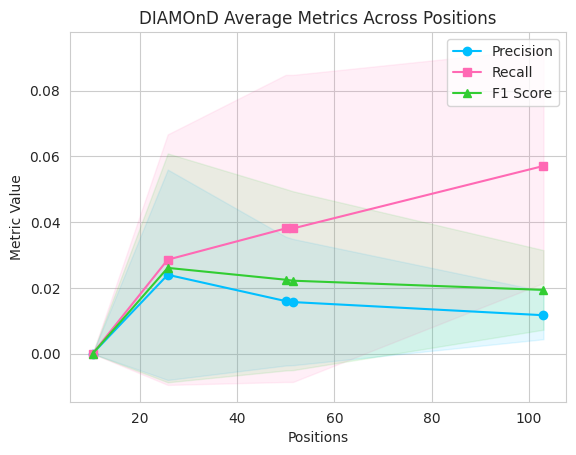

In [42]:
positions = [0.1*N, 0.25*N, 50, 0.5*N, N]

plt.plot(positions, avg_precision, label='Precision', marker='o', color='#00BFFF')
plt.plot(positions, avg_recall, label='Recall', marker='s', color='#FF69B4')
plt.plot(positions, avg_f1, label='F1 Score', marker='^', color='#32CD32')

# Visualizations
plt.fill_between(positions, np.array(avg_precision) - np.array(std_precision),
                 np.array(avg_precision) + np.array(std_precision),
                 alpha=0.1, color='#00BFFF')
plt.fill_between(positions, np.array(avg_recall) - np.array(std_recall),
                 np.array(avg_recall) + np.array(std_recall),
                 alpha=0.1, color='#FF69B4')
plt.fill_between(positions, np.array(avg_f1) - np.array(std_f1),
                 np.array(avg_f1) + np.array(std_f1),
                 alpha=0.1, color='#32CD32')

plt.xlabel('Positions')
plt.ylabel('Metric Value')
plt.title('DIAMOnD Average Metrics Across Positions')
plt.legend()
plt.grid(True)

plt.show()

Diable

In [43]:
avg_precision2 = []
std_precision2 = []
avg_recall2 = []
std_recall2 = []
avg_f1_2 = []
std_f1_2 = []

for position in top_X:
    precision_list = []
    recall_list = []
    f1_list = []

    # 5-folds cross validation
    for i in range(5):
        train = folds[:i] + folds[i+1:]
        train = [x for xs in train for x in xs]
        probe = folds[i]

        candidates = DiaBLE(G, train, int(position), 2, f'val_DiaBLE_{i}_iter_{position}.txt')
        candidates_i = [candidates[j][0][0] for j in range(len(candidates))]

        true_pos = len(set(candidates_i).intersection(set(probe)))
        false_pos = len(candidates_i) - true_pos
        false_neg = len(probe) - true_pos

        precision_i = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        recall_i = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i) if (precision_i + recall_i) > 0 else 0

        precision_list.append(precision_i)
        recall_list.append(recall_i)
        f1_list.append(f1_i)

    # Compute mean and standard deviation of those metrics
    avg_precision2.append(round(np.mean(precision_list),4))
    std_precision2.append(round(np.std(precision_list),4))
    avg_recall2.append(round(np.mean(recall_list),4))
    std_recall2.append(round(np.std(recall_list),4))
    avg_f1_2.append(round(np.mean(f1_list),4))
    std_f1_2.append(round(np.std(f1_list),4))

<ipython-input-22-5a2cd0e4741f>:26: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [44]:
metrics = [
    ['Metric', 'DIABlE'],
    ['Mean Precision',avg_precision2],
    ['Std Dev Precision', std_precision2],
    ['Mean Recall', avg_recall2],
    ['Std Dev Recall', std_recall2],
    ['Mean F1', avg_f1_2],
    ['Std Dev F1',std_f1_2]
]


metrics = tabulate(metrics, headers="firstrow", tablefmt="fancy_grid")
print(metrics)

╒═══════════════════╤═══════════════════════════════════════╕
│ Metric            │ DIABlE                                │
╞═══════════════════╪═══════════════════════════════════════╡
│ Mean Precision    │ [0.0, 0.008, 0.012, 0.0118, 0.0136]   │
├───────────────────┼───────────────────────────────────────┤
│ Std Dev Precision │ [0.0, 0.016, 0.0098, 0.0096, 0.0048]  │
├───────────────────┼───────────────────────────────────────┤
│ Mean Recall       │ [0.0, 0.0095, 0.0296, 0.0296, 0.0677] │
├───────────────────┼───────────────────────────────────────┤
│ Std Dev Recall    │ [0.0, 0.019, 0.0242, 0.0242, 0.0226]  │
├───────────────────┼───────────────────────────────────────┤
│ Mean F1           │ [0.0, 0.0087, 0.0171, 0.0168, 0.0226] │
├───────────────────┼───────────────────────────────────────┤
│ Std Dev F1        │ [0.0, 0.0174, 0.0139, 0.0137, 0.0079] │
╘═══════════════════╧═══════════════════════════════════════╛


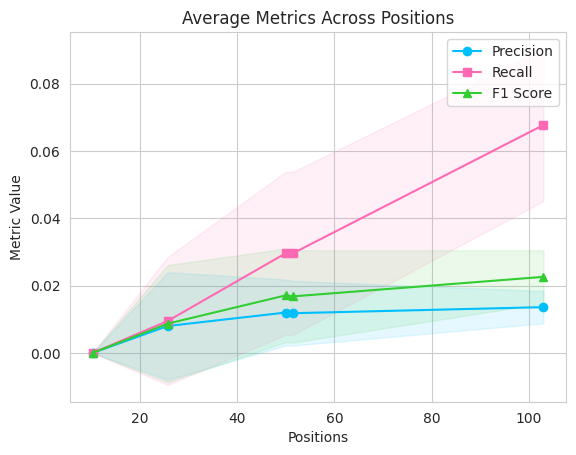

In [45]:
positions = [0.1*N, 0.25*N, 50, 0.5*N, N]

plt.plot(positions, avg_precision2, label='Precision', marker='o', color='#00BFFF')
plt.plot(positions, avg_recall2, label='Recall', marker='s', color='#FF69B4')
plt.plot(positions, avg_f1_2, label='F1 Score', marker='^', color='#32CD32')

# Visualizations
plt.fill_between(positions, np.array(avg_precision2) - np.array(std_precision2),
                 np.array(avg_precision2) + np.array(std_precision2),
                 alpha=0.1, color='#00BFFF')
plt.fill_between(positions, np.array(avg_recall2) - np.array(std_recall2),
                 np.array(avg_recall2) + np.array(std_recall2),
                 alpha=0.1, color='#FF69B4')
plt.fill_between(positions, np.array(avg_f1_2) - np.array(std_f1_2),
                 np.array(avg_f1_2) + np.array(std_f1_2),
                 alpha=0.1, color='#32CD32')

plt.xlabel('Positions')
plt.ylabel('Metric Value')
plt.title('Average Metrics Across Positions')
plt.legend()
plt.grid(True)
plt.show()

Diffusion based

In [46]:
avg_precision3 = []
std_precision3 = []
avg_recall3 = []
std_recall3 = []
avg_f1_3 = []
std_f1_3 = []

for position in top_X:
    precision_list = []
    recall_list = []
    f1_list = []

    # 5-folds cross validation
    for i in range(5):
        val_cyto_i = pd.read_csv("/content/val" + str(i) + ".csv")
        val_cyto_ranked = val_cyto_i.sort_values("diffusion_output_rank", ascending=True, ignore_index=True)
        cand_gene_i = list(val_cyto_ranked["name"])[:int(position)]

        true_pos = len(set(cand_gene_i).intersection(set(folds[i])))
        false_pos = len(cand_gene_i) - true_pos
        false_neg = len(folds[i]) - true_pos

        precision_i = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        recall_i = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i) if (precision_i + recall_i) > 0 else 0

        precision_list.append(precision_i)
        recall_list.append(recall_i)
        f1_list.append(f1_i)

    # Compute mean and standard deviation of those metrics
    avg_precision3.append(round(np.mean(precision_list),4))
    std_precision3.append(round(np.std(precision_list),4))
    avg_recall3.append(round(np.mean(recall_list),4))
    std_recall3.append(round(np.std(recall_list), 4))
    avg_f1_3.append(round(np.mean(f1_list), 4))
    std_f1_3.append(round(np.std(f1_list), 4))

In [47]:
metrics = [
    ['Metric', 'Diffusion Based'],
    ['Mean Precision',avg_precision3],
    ['Std Dev Precision', std_precision3],
    ['Mean Recall', avg_recall3],
    ['Std Dev Recall', std_recall3],
    ['Mean F1', avg_f1_3],
    ['Std Dev F1',std_f1_3]
]


metrics = tabulate(metrics, headers="firstrow", tablefmt="fancy_grid")
print(metrics)

╒═══════════════════╤══════════════════════════════════════════╕
│ Metric            │ Diffusion Based                          │
╞═══════════════════╪══════════════════════════════════════════╡
│ Mean Precision    │ [0.2, 0.2, 0.2, 0.2, 0.1553]             │
├───────────────────┼──────────────────────────────────────────┤
│ Std Dev Precision │ [0.1095, 0.062, 0.0379, 0.038, 0.0061]   │
├───────────────────┼──────────────────────────────────────────┤
│ Mean Recall       │ [0.0952, 0.2421, 0.4832, 0.4927, 0.7779] │
├───────────────────┼──────────────────────────────────────────┤
│ Std Dev Recall    │ [0.0522, 0.0716, 0.0797, 0.0811, 0.044]  │
├───────────────────┼──────────────────────────────────────────┤
│ Mean F1           │ [0.129, 0.219, 0.2828, 0.2844, 0.2589]   │
├───────────────────┼──────────────────────────────────────────┤
│ Std Dev F1        │ [0.0707, 0.0664, 0.0517, 0.052, 0.0103]  │
╘═══════════════════╧══════════════════════════════════════════╛


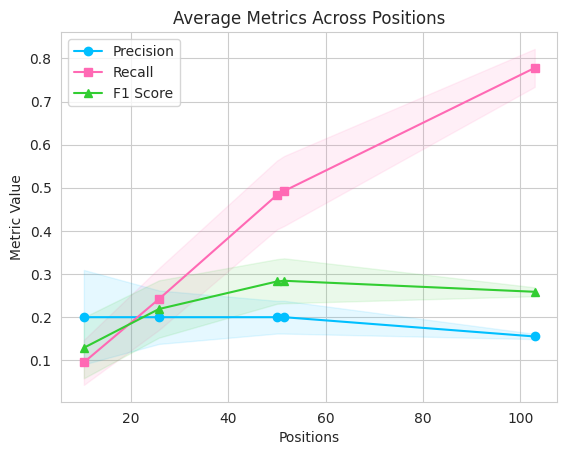

In [48]:
positions = [0.1*N, 0.25*N, 50, 0.5*N, N]

plt.plot(positions, avg_precision3, label='Precision', marker='o', color='#00BFFF')
plt.plot(positions, avg_recall3, label='Recall', marker='s', color='#FF69B4')
plt.plot(positions, avg_f1_3, label='F1 Score', marker='^', color='#32CD32')

# Visualizations
plt.fill_between(positions, np.array(avg_precision3) - np.array(std_precision3),
                 np.array(avg_precision3) + np.array(std_precision3),
                 alpha=0.1, color='#00BFFF')
plt.fill_between(positions, np.array(avg_recall3) - np.array(std_recall3),
                 np.array(avg_recall3) + np.array(std_recall3),
                 alpha=0.1, color='#FF69B4')
plt.fill_between(positions, np.array(avg_f1_3) - np.array(std_f1_3),
                 np.array(avg_f1_3) + np.array(std_f1_3),
                 alpha=0.1, color='#32CD32')

plt.xlabel('Positions')
plt.ylabel('Metric Value')
plt.title('Average Metrics Across Positions')
plt.legend()
plt.grid(True)
plt.show()

## **3. Putative disease gene identification**


## 3.1 Predict new putative disease genes using all known GDAs as seed genes

In [49]:
with open("seed_genes.txt", "w") as f:
  for item in seed_genes:
    f.write(item +"\n")

In [50]:
with open("CYTO002_100_candidates.txt", "w") as f:
  for item in g002:
    f.write(item + "\n")

## **4. Drug repurposing**

## 4.1. Drug identification


In [56]:
putative_20 = g002[:20]
with open("CYTO002_100_candidates.txt", "w") as f:
  for item in g002:
    f.write(item + "\n")

['HSPA6',
 'CBX6',
 'CRSP5',
 'MCM3AP',
 'SOS2',
 'MRPL16',
 'OSMR',
 'CAND1',
 'ADRB3',
 'POLR2F',
 'MYO6',
 'XRCC5',
 'LGALS3',
 'TARS2',
 'ATP6',
 'OXA1L',
 'ABCG5',
 'VCP',
 'DLX5',
 'CX3CR1']

In [6]:
drug= pd.read_csv('/content/gene_interaction_results-21_06_2024.tsv', sep='\t')

In [13]:
approved_data = drug[drug['regulatory approval'] == 'Approved']
approved_data.head()

,gene,drug,regulatory approval,indication,interaction score
12,ADRB3,CARTEOLOL HYDROCHLORIDE,Approved,NaN,0.500073
13,ADRB3,VIBEGRON,Approved,NaN,1.500219
14,ADRB3,OLANZAPINE,Approved,"for treatment of bipolar disorder,antidepressa...",0.039479
15,ADRB3,NOREPINEPHRINE BITARTRATE,Approved,NaN,0.166691
16,ADRB3,MIRABEGRON,Approved,for treatment of overactive bladder,0.900132


In [16]:
drug_gene_counts = approved_data.groupby('drug')['gene'].nunique().reset_index()
drug_gene_counts.columns = ['drug', 'gene_count']
# Sort drugs in descending order
sorted_drug_gene_counts = drug_gene_counts.sort_values(by='gene_count', ascending=False)

In [18]:
print("Ranking of Identified Drugs:")
for rank, row in enumerate(sorted_drug_gene_counts.itertuples(index=False), start=1):
    drug = row.drug
    count = row.gene_count
    related_genes = approved_data[approved_data['drug'] == drug]['gene'].unique()
    gene_list = ', '.join(related_genes)
    print(f"{rank}. {drug}: {count} genes - Genes: {gene_list}")

Ranking of Identified Drugs:
1. 4-PHENYLBUTYRIC ACID: 1 genes - Genes: XRCC5
2. CAMPTOTHECIN: 1 genes - Genes: XRCC5
3. TRIHEXYPHENIDYL: 1 genes - Genes: ADRB3
4. THALIDOMIDE: 1 genes - Genes: XRCC5
5. RIMITEROL: 1 genes - Genes: ADRB3
6. OLANZAPINE: 1 genes - Genes: ADRB3
7. NOREPINEPHRINE BITARTRATE: 1 genes - Genes: ADRB3
8. MIRABEGRON: 1 genes - Genes: ADRB3
9. MEPHENTERMINE SULFATE: 1 genes - Genes: ADRB3
10. LABETALOL HYDROCHLORIDE: 1 genes - Genes: ADRB3
11. ISOPROTERENOL SULFATE: 1 genes - Genes: ADRB3
12. ISOPROTERENOL: 1 genes - Genes: ADRB3
13. HYDROXYAMPHETAMINE HYDROBROMIDE: 1 genes - Genes: ADRB3
14. HYDROGEN PEROXIDE: 1 genes - Genes: XRCC5
15. HEXACHLOROPHENE: 1 genes - Genes: VCP
16. EPINEPHRINE BITARTRATE: 1 genes - Genes: ADRB3
17. EPINEPHRINE: 1 genes - Genes: ADRB3
18. EPHEDRINE HYDROCHLORIDE: 1 genes - Genes: ADRB3
19. EPHEDRINE: 1 genes - Genes: ADRB3
20. DROXIDOPA: 1 genes - Genes: ADRB3
21. DIPIVEFRIN HYDROCHLORIDE: 1 genes - Genes: ADRB3
22. DILEVALOL HYDROCHL

In [19]:
table = tabulate(sorted_drug_gene_counts.head(), headers='keys', tablefmt='fancy_grid')
print(table)

╒════╤══════════════════════╤══════════════╕
│    │ drug                 │   gene_count │
╞════╪══════════════════════╪══════════════╡
│  0 │ 4-PHENYLBUTYRIC ACID │            1 │
├────┼──────────────────────┼──────────────┤
│  1 │ CAMPTOTHECIN         │            1 │
├────┼──────────────────────┼──────────────┤
│ 24 │ TRIHEXYPHENIDYL      │            1 │
├────┼──────────────────────┼──────────────┤
│ 23 │ THALIDOMIDE          │            1 │
├────┼──────────────────────┼──────────────┤
│ 22 │ RIMITEROL            │            1 │
╘════╧══════════════════════╧══════════════╛
